# 커스텀 데이터 영상 분류 학습

# 데이터 준비


<br>

데이터는 다음과 같이 구성됨

```
dogs/
    train/
        class1/
            file1.jpg
            file2.jpg
             ...
        class2/ 
            file21.jpg
            file22.jpg
             ...    
        class3/
            file31.jpg
            file32.jpg
             ...
        ...
    test/
        class1/
            file8.jpg
            file9.jpg
             ...
        class2/ 
            file28.jpg
            file29.jpg
             ...    
        class3/
            file38.jpg
            file39.jpg
             ...
        ...
    
```

In [1]:
!rm -rf flowers.zip
!wget https://github.com/dhrim/jetson_image/raw/master/data/flowers.zip
!ls -al  

--2021-10-27 00:56:01--  https://github.com/dhrim/jetson_image/raw/master/data/flowers.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/jetson_image/master/data/flowers.zip [following]
--2021-10-27 00:56:01--  https://raw.githubusercontent.com/dhrim/jetson_image/master/data/flowers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62614285 (60M) [application/zip]
Saving to: ‘flowers.zip’

flowers.zip         100%[===================>]  59.71M   270MB/s    in 0.2s    

2021-10-27 00:56:03 (270 MB/s) - ‘flowers.zip’ saved [62614285/62614285]

total 61164
drwxr-xr-x 1 root root     4096 

In [3]:
!rm -rf flowers
!unzip flowers.zip
!ls -al flowers

Archive:  flowers.zip
   creating: flowers/
   creating: flowers/test/
  inflating: flowers/test/.DS_Store  
   creating: flowers/test/daisy/
  inflating: flowers/test/daisy/348.jpg  
  inflating: flowers/test/daisy/360.jpg  
  inflating: flowers/test/daisy/406.jpg  
  inflating: flowers/test/daisy/412.jpg  
  inflating: flowers/test/daisy/374.jpg  
  inflating: flowers/test/daisy/413.jpg  
  inflating: flowers/test/daisy/375.jpg  
  inflating: flowers/test/daisy/361.jpg  
  inflating: flowers/test/daisy/407.jpg  
  inflating: flowers/test/daisy/349.jpg  
  inflating: flowers/test/daisy/388.jpg  
  inflating: flowers/test/daisy/439.jpg  
  inflating: flowers/test/daisy/377.jpg  
  inflating: flowers/test/daisy/411.jpg  
  inflating: flowers/test/daisy/405.jpg  
  inflating: flowers/test/daisy/363.jpg  
  inflating: flowers/test/daisy/404.jpg  
  inflating: flowers/test/daisy/362.jpg  
  inflating: flowers/test/daisy/376.jpg  
  inflating: flowers/test/daisy/410.jpg  
  inflating: flowe

# 학습을 위해 수정할 사항

In [5]:
DATA_NAME = "flowers"

# 모델 학습

In [9]:
temp_generator = ImageDataGenerator().flow_from_directory(DATA_NAME+"/train",)
custom_labels = list(temp_generator.class_indices.keys())
print("load labels. labels=",custom_labels)
CATEGORY_COUNT = len(custom_labels)

Found 1500 images belonging to 5 classes.
load labels. labels= ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_1 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               17662208  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
model_output (Dense)         (None, 5)                 1285      
Total params: 25,433,086
Trainable params: 17,664,005
Non-trainable params: 7,769,081
_________________________________________________________________
Found 1500 images belonging to 5 classes.
Found 711 images belonging to 5 classes.
Epoch 1/10
24/24 

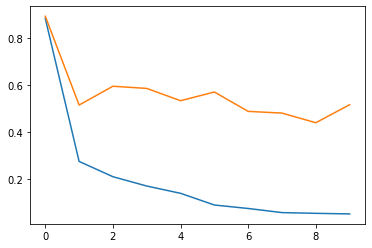

12/12 [==============================] - 2s 143ms/step - loss: 0.5159 - acc: 0.8776
loss= 0.5158739686012268
acc= 0.8776371479034424


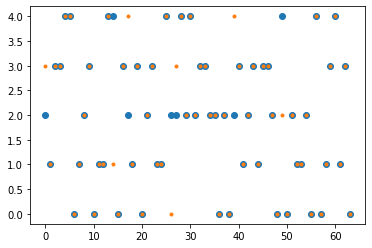

label category index = 2.0
predicted category index = 3
predicted category name = sunflower


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False
conv_layers._name = "model"

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(CATEGORY_COUNT, activation='softmax', name="model_output"))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      DATA_NAME+"/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      DATA_NAME+"/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = test_data_generator.next()
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# 레이블링 파일 작성

In [ ]:
f = open("labels.txt", "w")
f.write("\n".join(custom_labels))
f.close()

In [ ]:
!cat labels.txt

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound

# 모델을 tf 포멧으로 저장

In [ ]:
import os
import tensorflow as tf

model.save("model.tf", save_format="tf")

INFO:tensorflow:Assets written to: model.tf/assets


# tf2onnx 설치


In [ ]:
!pip3 install tf2onnx

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# 모델을 onnx로 변환

In [ ]:
!python -m tf2onnx.convert --opset 10 --saved-model model.tf --output model.onnx --inputs model_input:0[1,224,224,3]

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-10-27 00:59:38,164 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2021-10-27 00:59:38,640 - WARNING - Importing a function (__inference_block5d_activation_layer_call_and_return_conditional_losses_268573) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-10-27 00:59:38,673 - WARNING - Importing a function (__inference_block4d_se_reduce_layer_call_and_return_conditional_losses_266913) with ops with cus